## Is it a Brain or a VNC?

In [55]:
# Needed to run on Macbook M1
import os
os.environ["OMP_NUM_THREADS"] = "1" 

from fastcore.all import *
from fastai.vision.all import *

## Define the training/validation sets

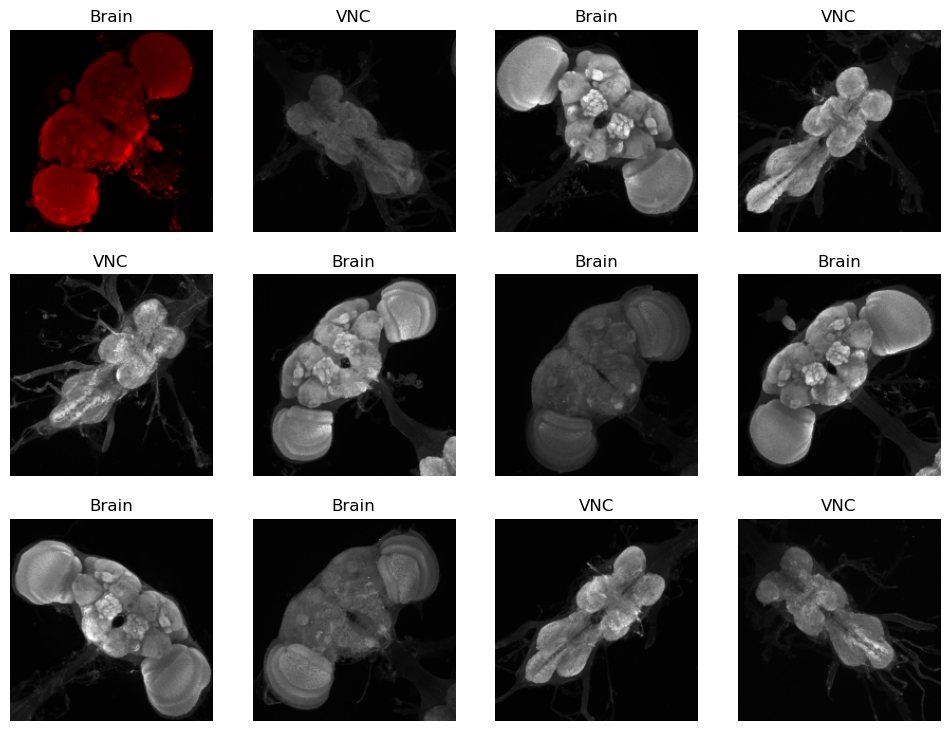

In [39]:
training_path = Path('anatomical_area/training')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(training_path)

dls.show_batch(max_n=12)

## Fine tune the model

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/rokickik/opt/miniconda3/envs/course22/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/rokickik/opt/miniconda3/envs/course22/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.386122,0.099212,0.025000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.001396,0.000053,0.000000,00:04
1,0.000665,0.000013,0.000000,00:04
2,0.000550,0.000012,0.000000,00:04


## Run the test set


In [35]:
test_path = Path('anatomical_area/test')

wrongs = []
unconfidents = []
area_classes = ("Brain","VNC")

with learn.no_bar(), learn.no_logging():
    for area in area_classes:
        for image_path in get_image_files(test_path / area):
            predicted_area,_,probs = learn.predict(PILImage.create(image_path))
            pred_index = area_classes.index(predicted_area)
            pred_prob = probs[pred_index]
            if predicted_area != area:
                print(f"Predicted {predicted_area} for {image_path} incorrectly with probability {pred_prob:.6f}")
                wrongs.append(image_path)
            if pred_prob < 0.99:
                print(f"Predicted {predicted_area} for {image_path} with probability {pred_prob:.6f}")
                unconfidents.append(image_path)
    


Predicted VNC for anatomical_area/test/VNC/JRC_SS65417-20220909_47_B2.png with probability 0.988963
Predicted VNC for anatomical_area/test/VNC/JRC_SS72288-20220916_44_B5.png with probability 0.728101


## Show images that were correctly but unconfidently predicted

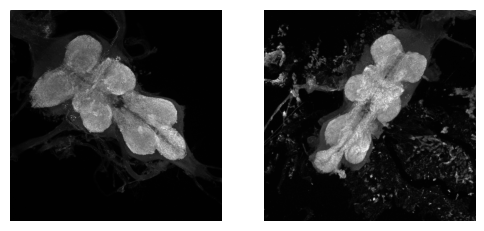

In [54]:
show_images([PILImage.create(p) for p in unconfidents])